# Pr√©dire les sinistres (demande d'indemnisation)

*(Si vous n‚Äôavez pas ces packages, installez‚Äëles avec `pip install pandas seaborn matplotlib`.)*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus lisible
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Chargement du jeu de donn√©es
Nous utilisons un fichier CSV contenant¬†:

| Colonne | Signification | Exemple |
|---------|---------------|---------|
| `age` | √Çge de l‚Äôassur√©¬∑e | 29 |
| `sex` | Genre (male / female) | female |
| `bmi` | Indice de Masse Corporelle | 27.9 |
| `bloodpressure` | Tension art√©rielle moyenne | 125 |
| `children` | Nombre d‚Äôenfants √† charge | 2 |
| `smoker` | Statut fumeur (yes / no) | yes |
| `region` | Zone g√©ographique | southwest |
| `charges` | Montant du sinistre (‚Ç¨) | 16‚ÄØ854 |

Ces variables sont couramment utilis√©es par les actuaires pour segmenter le risque et ajuster la prime d‚Äôassurance.

In [19]:
# Modifiez le chemin si n√©cessaire
file_path = 'datasets/insurance-demographic-health.csv'

data = pd.read_csv(file_path)
print(f"Dimensions : {data.shape}")
data.head()

Dimensions : (1340, 11)


index  PatientID   age gender   bmi  bloodpressure diabetic  children  \
0      0          1  39.0   male  23.2             91      Yes         0   
1      1          2  24.0   male  30.1             87       No         0   
2      2          3   NaN   male  33.3             82      Yes         0   
3      3          4   NaN   male  33.7             80       No         0   
4      4          5   NaN   male  34.1            100       No         0   

  smoker     region    claim  
0     No  southeast  1121.87  
1     No  southeast  1131.51  
2     No  southeast  1135.94  
3     No  northwest  1136.40  
4     No  northwest  1137.01

In [20]:
df = data.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


## 3. Nettoyage des donn√©es
Dans un contexte d‚Äôassurance, **la qualit√© des donn√©es est critique**¬†:
1. Les valeurs manquantes peuvent biaiser les calculs de fr√©quence et de co√ªt moyen.
2. Les doublons faussent les statistiques (par ex. un assur√© compt√© deux fois).

Nous allons :
* d√©tecter les lignes concern√©es ;
* les supprimer pour simplifier (d‚Äôautres options‚ÄØ: imputation, correction manuelle).

> En production, un pipeline de Data‚ÄØEngineering/ETL g√®re g√©n√©ralement ces √©tapes automatiquement.

In [ ]:
df.isnull().any()

index            False
PatientID        False
age               True
gender           False
bmi              False
bloodpressure    False
diabetic         False
children         False
smoker           False
region            True
claim            False
dtype: bool

<Axes: >

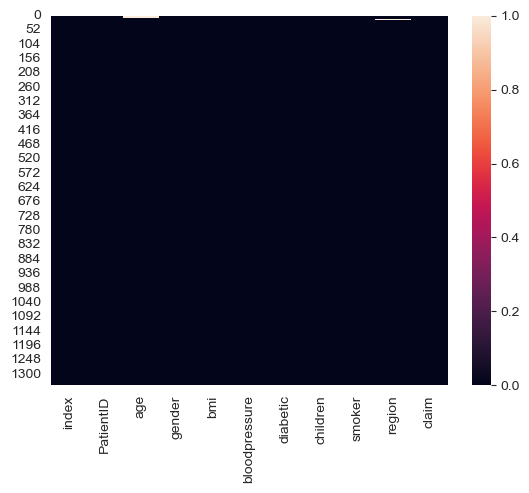

In [23]:
sns.heatmap(df.isnull())

In [24]:
(df.isna().sum() / len(df)) * 100

index            0.000000
PatientID        0.000000
age              0.373134
gender           0.000000
bmi              0.000000
bloodpressure    0.000000
diabetic         0.000000
children         0.000000
smoker           0.000000
region           0.223881
claim            0.000000
dtype: float64

- Les valeurs manquantes representent moins de `1%` du jeu de donn√©es

In [25]:
# --- Valeurs manquantes ---
missing_rows = df[df.isnull().any(axis=1)]
print(f"Lignes avec au moins une valeur manquante : {len(missing_rows)}")

# --- Doublons ---
duplicate_rows = df[df.duplicated()]
print(f"Lignes dupliqu√©es : {len(duplicate_rows)}")

# Suppression (conservative)
df = df.dropna().drop_duplicates()
print("Dimensions apr√®s nettoyage :", df.shape)

Lignes avec au moins une valeur manquante : 8
Lignes dupliqu√©es : 0
Dimensions apr√®s nettoyage : (1332, 11)


> **Pourquoi ne pas toujours imputer‚ÄØ?**
>
> * Dans l‚Äôassurance sant√©, remplacer une tension manquante par la moyenne peut masquer un risque r√©el.
> * Pour un exercice p√©dagogique, il est plus simple de supprimer ‚Äì mais retenez qu‚Äôen production on privil√©gie l‚Äôimputation supervis√©e ou la collecte de donn√©es manquantes aupr√®s de l‚Äôassur√©.

## 4. √Çge, genre et montant des sinistres
Les assureurs v√©rifient souvent si le **co√ªt moyen** √©volue avec l‚Äô√¢ge et diff√®re selon le genre.

In [26]:
df.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [37]:
df['bmi'].max()

53.1

In [32]:
numerical=df.select_dtypes(exclude='object')

<Axes: >

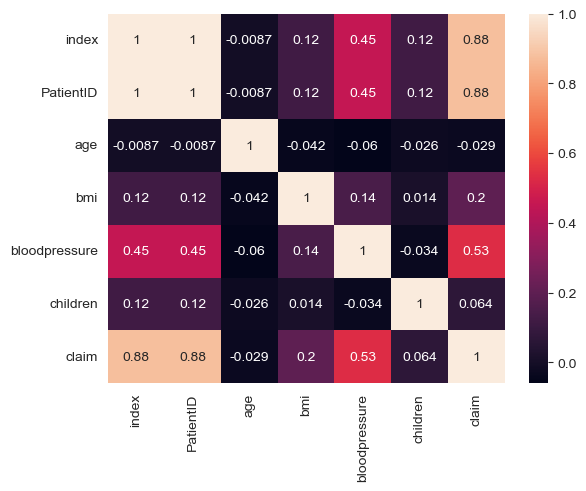

In [ ]:
sns.heatmap(numerical.corr(), annot=True) 

In [38]:
# Corr√©lation lin√©aire √¢ge ‚Üî charges
age_claim_corr = df['age'].corr(df['claim'])
print(f"Corr√©lation √¢ge / charges : {age_claim_corr:.3f}")

Corr√©lation √¢ge / charges : -0.029


In [39]:
# Statistiques par genre
stats_genre = df.groupby('gender')['claim'].agg(mean='mean', median='median', count='size')
stats_genre

mean    median  count
gender                               
female  12569.578897  9412.965    662
male    14071.891060  9439.495    670

### Visualisation

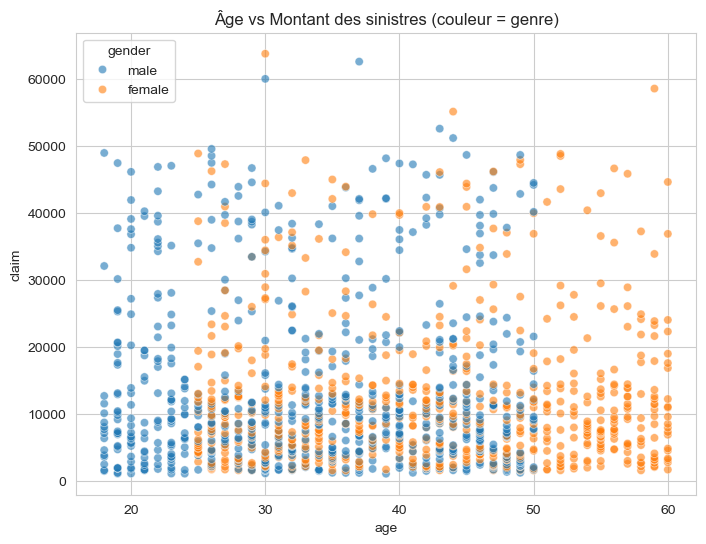

/var/folders/8f/x3gnhxrs2mv8f434z6w6qyw40000gn/T/ipykernel_57823/3821631342.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')


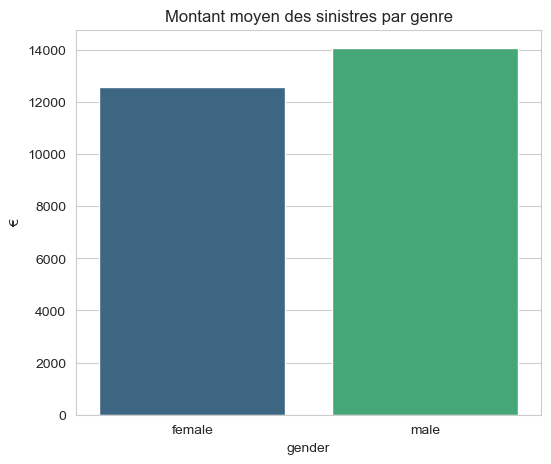

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='claim', hue='gender', data=df, alpha=0.6)
plt.title('√Çge vs Montant des sinistres (couleur = genre)')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')
plt.title('Montant moyen des sinistres par genre')
plt.ylabel('‚Ç¨')
plt.show()

**Interpr√©tation :**
* Un coefficient proche de 0 signifie peu ou pas de relation **lin√©aire**. D‚Äôautres formes (non‚Äëlin√©aires) peuvent exister.
* Si les hommes ont un co√ªt moyen plus √©lev√©, cela peut venir de comportements de risque (tabagisme, IMC, etc.).


## 5. IMC, tension art√©rielle et sinistres
L‚ÄôIMC et la tension sont deux indicateurs de sant√© cl√©s.
* **IMC √©lev√©**‚ÄØ: risque d‚Äôob√©sit√© ‚Üí maladies cardiovasculaires ‚áí co√ªts √©lev√©s.
* **Hypertension**‚ÄØ: facteur de risque majeur pour AVC / infarctus.

In [48]:
corr_age = df['age'].corr(df['bloodpressure'])
corr_bmi = df['bmi'].corr(df['claim'])
corr_bp  = df['bloodpressure'].corr(df['claim'])
print(f"Corr√©lation IMC / charges : {corr_bmi *100:.2f} %")
print(f"Corr√©lation tension / charges : {corr_bp*100:.2f} %")
print(f"Corr√©lation age / tension arterielle : {corr_age*100:.2f} %")

Corr√©lation IMC / charges : 19.99 %
Corr√©lation tension / charges : 53.13 %
Corr√©lation age / tension arterielle : -6.03 %


In [49]:
df.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

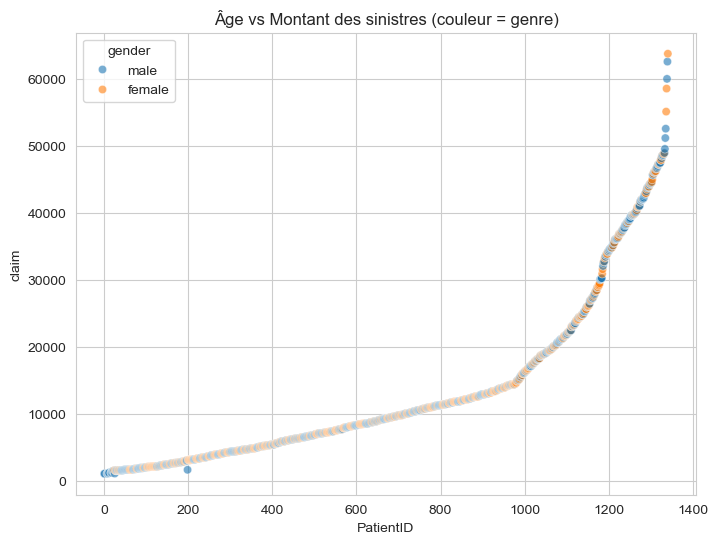

/var/folders/8f/x3gnhxrs2mv8f434z6w6qyw40000gn/T/ipykernel_57823/2277811781.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')


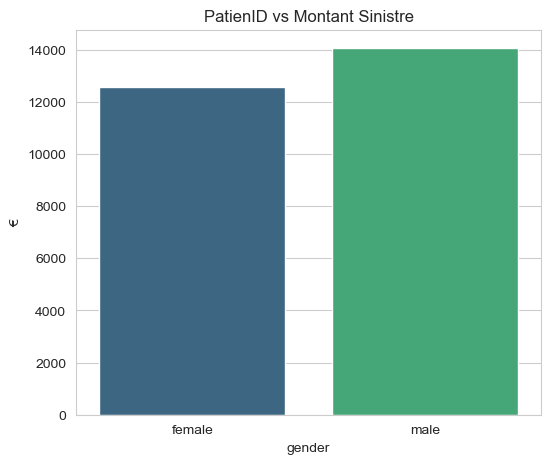

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PatientID', y='claim', hue='gender', data=df, alpha=0.6)
plt.title('√Çge vs Montant des sinistres (couleur = genre)')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x=stats_genre.index, y='mean', data=stats_genre.reset_index(), palette='viridis')
plt.title('PatienID vs Montant Sinistre')
plt.ylabel('‚Ç¨')
plt.show()

In [54]:
df.tail(10)

index  PatientID   age  gender   bmi  bloodpressure diabetic  children  \
1330   1330       1331  25.0  female  38.1            111       No         0   
1331   1331       1332  18.0    male  41.1            104       No         1   
1332   1332       1333  26.0    male  37.0            120       No         2   
1333   1333       1334  44.0    male  36.4            127       No         1   
1334   1334       1335  43.0    male  32.8            125       No         0   
1335   1335       1336  44.0  female  35.5             88      Yes         0   
1336   1336       1337  59.0  female  38.1            120       No         1   
1337   1337       1338  30.0    male  34.5             91      Yes         3   
1338   1338       1339  37.0    male  30.4            106       No         0   
1339   1339       1340  30.0  female  47.4            101       No         0   

     smoker     region     claim  
1330    Yes  southeast  48885.14  
1331    Yes  southeast  48970.25  
1332    Yes  southeast  49577.66  
1333    Yes  southwest  51194.56  
1334    Yes  southwest  52590.83  
1335    Yes  northwest  55135.40  
1336    Yes  northeast  58571.07  
1337    Yes  northwest  60021.40  
1338    Yes  southeast  62592.87  
1339    Yes  southeast  63770.43

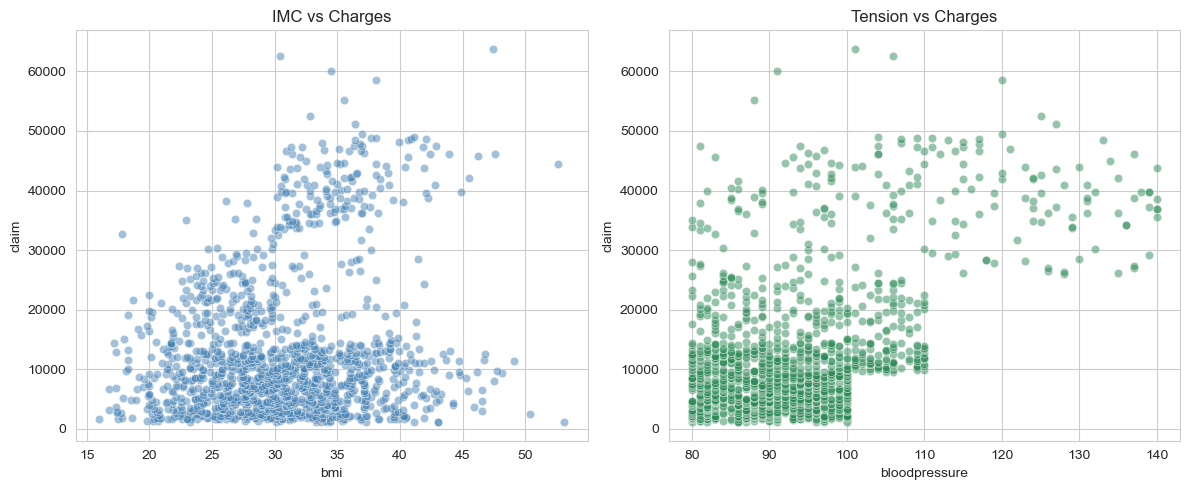

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(data=data, x='bmi', y='claim', alpha=0.5, color='steelblue')
plt.title('IMC vs Charges')
plt.subplot(1,2,2)
sns.scatterplot(data=data, x='bloodpressure', y='claim', alpha=0.5, color='seagreen')
plt.title('Tension vs Charges')
plt.tight_layout()
plt.show()

On observe g√©n√©ralement une relation **positive**‚ÄØ: plus l‚ÄôIMC ou la tension augmentent, plus le co√ªt des sinistres tend √† cro√Ætre. Ces informations sont utilis√©es dans les **questionnaires de sant√©** pour ajuster la prime.

In [57]:
# Statistiques par genre
stats_genre = df.groupby('gender')['bloodpressure'].agg(mean='mean', median='median', count='size')
stats_genre

mean  median  count
gender                          
female  94.013595    93.0    662
male    94.362687    92.0    670

## 6. Impact du tabagisme
Le tabagisme est souvent la variable la plus discriminante pour les assureurs sant√©.

In [58]:
data.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [59]:
data.sample(5)

index  PatientID   age  gender   bmi  bloodpressure diabetic  children  \
492    492        493  27.0    male  30.9             91       No         3   
539    539        540  51.0  female  26.4             97       No         0   
266    266        267  53.0  female  28.9             93       No         0   
509    509        510  50.0  female  20.0             89      Yes         2   
915    915        916  49.0  female  18.3             82      Yes         0   

    smoker     region     claim  
492     No  northwest   6796.86  
539     No  northwest   7419.48  
266     No  southeast   3972.92  
509     No  southeast   7133.90  
915     No  northeast  13204.29

In [60]:
mean_smoker = df.loc[df['smoker']=='Yes','claim'].mean()
mean_nonsmoker = df.loc[df['smoker']=='No','claim'].mean()
print(f"Co√ªt moyen fumeurs    : {mean_smoker:,.2f} ‚Ç¨")
print(f"Co√ªt moyen non‚Äëfumeurs : {mean_nonsmoker:,.2f} ‚Ç¨")

df['smoker_bin'] = df['smoker'].map({'No':0,'Yes':1})
corr_smoker = df['smoker_bin'].corr(df['claim'])
print(f"Corr√©lation (binaire) tabagisme / charges : {corr_smoker:.3f}")

Co√ªt moyen fumeurs    : 32,050.23 ‚Ç¨
Co√ªt moyen non‚Äëfumeurs : 8,475.86 ‚Ç¨
Corr√©lation (binaire) tabagisme / charges : 0.787


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


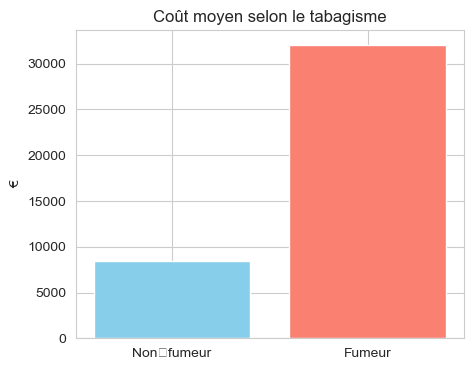

In [61]:
plt.figure(figsize=(5,4))
plt.bar(['Non‚Äëfumeur','Fumeur'], [mean_nonsmoker, mean_smoker], color=['skyblue','salmon'])
plt.title('Co√ªt moyen selon le tabagisme')
plt.ylabel('‚Ç¨')
plt.show()

La corr√©lation √©lev√©e (>‚ÄØ0.7) indique que **fumer augmente fortement le co√ªt des soins**.

> Dans certains pays, les assureurs appliquent une surprime ou imposent un d√©lai de carence aux fumeurs.

## 7. Importance des variables avec Random¬†Forest
Pour pr√©dire le co√ªt (`charges`), nous souhaitons conna√Ætre les variables les plus utiles. La **For√™t Al√©atoire** fournit un score d‚Äôimportance bas√© sur la r√©duction d‚Äôimpuret√©.

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Encodage des colonnes cat√©gorielles
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop(columns=['claim'])
y = df['claim']

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

RandomForestRegressor(n_estimators=300, random_state=42)

In [63]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

PatientID        5.029484e-01
index            4.968701e-01
age              4.357907e-05
bmi              4.090678e-05
bloodpressure    3.358836e-05
region           3.029703e-05
children         2.063533e-05
gender           6.914092e-06
diabetic         4.003952e-06
smoker           7.971053e-07
smoker_bin       7.686051e-07
dtype: float64

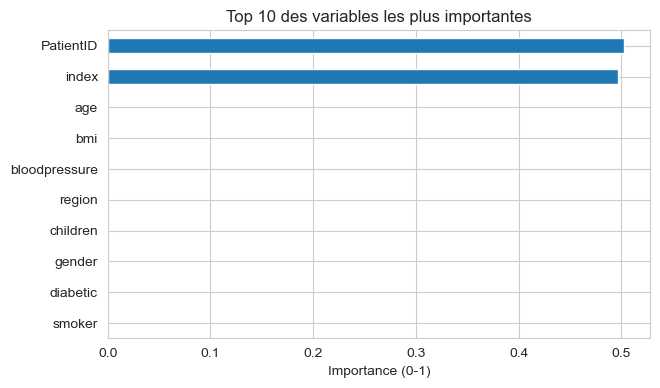

In [64]:
plt.figure(figsize=(7,4))
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 des variables les plus importantes')
plt.xlabel('Importance (0-1)')
plt.show()

**Comment utiliser cette information‚ÄØ?**
* Donner plus de poids aux variables cl√©s dans la tarification.
* R√©duire la dimensionnalit√© (simplifier le questionnaire client).
* Communiquer sur les facteurs de risque majeurs aupr√®s des assur√©s.

# Modelisation¬†:

Apr√®s avoir √©tudi√© l‚Äôimpact de chaque variable et extrait les facteurs cl√©s, 
passons maintenant √† la **pr√©diction avanc√©e** avec deux algorithmes de boosting d‚Äôarbres¬†:

* **XGBoost** ‚Äì souvent champion des comp√©titions Kaggle, robuste aux interactions non lin√©aires.
* **LightGBM** ‚Äì impl√©mentation Microsoft, tr√®s rapide et efficace sur gros volumes.

Nous r√©utiliserons le jeu de donn√©es nettoy√© et encod√©, puis comparerons leurs performances (MAE, R¬≤).

## Encodage des variables cat√©gorielles

In [65]:
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

## Split train / test

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X = df.drop(columns=['claim'])
y = df['claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

## Mod√®le XGBoost (Extreme Gradient Boosting)

### 1. Principe g√©n√©ral

| üîç                 | Description                                                                                                                                        |
| ------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Boosting**       | Entra√Æne une succession d‚Äôarbres de d√©cision **faibles** ; chaque nouvel arbre corrige les erreurs cumul√©es des pr√©c√©dents.                        |
| **Gradient**       | L‚Äôerreur r√©siduelle est minimis√©e : on calcule le **gradient** (d√©riv√©e) de la fonction perte pour savoir dans quelle direction ajuster le mod√®le. |
| **Regularisation** | Ajoute un terme de p√©nalit√© (L1/L2) sur la complexit√© de l‚Äôarbre pour √©viter l‚Äôoverfitting.                                                        |
| **Parall√©lisme**   | Construction des arbres optimis√©e (histogram-based + multi-thread) ‚Üí entra√Ænement rapide m√™me sur gros jeux de donn√©es.                            |

### 2. Pourquoi XGBoost est performant sur les sinistres ?

* **Relations non lin√©aires** : le co√ªt d‚Äôun sinistre sant√© n‚Äôest pas strictement lin√©aire (effet multiplicatif entre √¢ge, IMC, tabagisme‚Ä¶). Les arbres g√®rent ces interactions naturellement.
* **Robuste aux valeurs aberrantes** : quelques cas de sinistres tr√®s chers (queue heavy-tailed) n‚Äôinfluencent pas outre mesure la pr√©diction globale.
* **Gestion du d√©s√©quilibre** : param√®tre `scale_pos_weight` (en classification) ou pond√©rations par observation pour sur-repr√©senter les sinistres rares mais co√ªteux.
* **Importance des variables** : fournit des scores ¬´ gain ¬ª ou ¬´ cover ¬ª utiles pour expliquer la tarification.

### 3. Avantages

| ‚úÖ                             | D√©tails                                                                 |
| ----------------------------- | ----------------------------------------------------------------------- |
| **Excellente pr√©cision**      | Souvent vainqueur de comp√©titions Kaggle et benchmarks industriels.     |
| **Contr√¥le overfitting**      | Param√®tres `gamma`, `lambda`, `alpha`, `subsample`‚Ä¶                     |
| **Feature importance**        | Facile √† extraire et √† visualiser (gain, cover, weight).                |
| **Tol√®re donn√©es manquantes** | Choisit automatiquement la meilleure direction de branchement pour NaN. |

### 4. Inconv√©nients / limites

| ‚ö†Ô∏è                           | Impact                                                                                                             |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Hyperparam√®tres nombreux** | GridSearch long ; n√©cessite une bonne ma√Ætrise pour √©quilibrer biais/variance.                                     |
| **Taille m√©moire**           | Mod√®les volumineux avec beaucoup d‚Äôarbres ‚Üí empreinte RAM plus √©lev√©e qu‚Äôun mod√®le lin√©aire.                       |
| **Explicabilit√© partielle**  | Importance globale OK, mais explication locale moins intuitive qu‚Äôune r√©gression logistique (n√©cessite SHAP/LIME). |

In [68]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

In [69]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=4,
                   subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
print('MAE XGB:', mean_absolute_error(y_test, pred_xgb))
print('R¬≤ XGB :', r2_score(y_test, pred_xgb))

MAE XGB: 135.20602017863408
R¬≤ XGB : 0.9988208233710018


## LightGBM

## Mod√®le LightGBM (Light Gradient Boosting Machine)

### 1. Principe g√©n√©ral

| üîç                     | Description                                                                                                                                                         |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Leaf-Wise Growth**   | Contrairement √† XGBoost (level-wise), LightGBM grandit d‚Äôabord **la branche la plus prometteuse** (leaf-wise) ‚Üí perte r√©duite plus vite.                            |
| **Histogram-Based**    | Les valeurs continues sont discr√©tis√©es en bacs ; acc√©l√®re le tri et r√©duit la m√©moire.                                                                             |
| **GOSS & EFB**         | *Gradient-Based One-Side Sampling* s√©lectionne les instants ayant les gradients les plus grands ; *Exclusive Feature Bundling* compacte les features peu corr√©l√©es. |
| **Cat√©gories natives** | Accepte des entiers repr√©sentant les modalit√©s sans one-hot, en appliquant un regroupement optimal.                                                                 |

### 2. Pourquoi LightGBM brille pour le pricing sinistre ?

* **Rapidit√©** : permet des it√©rations rapides sur de gros portefeuilles (millions de contrats).
* **Scalabilit√© verticale** : moins gourmand en m√©moire ‚Üí entra√Æne un mod√®le complet sur un laptop √©tudiant.
* **Gestion des interactions** : comme XGBoost, capture efficacement les effets combinatoires (ex. r√©gion √ó cat√©gorie socio-pro) impactant le co√ªt.
* **Support des variables cat√©gorielles** : √©vite le *curse of dimensionality* d√ª au one-hot (ex. 50 r√©gions ‚Üí 50 colonnes).

### 3. Avantages

| ‚úÖ                                      | D√©tails                                                               |
| -------------------------------------- | --------------------------------------------------------------------- |
| **Entra√Ænement ultra-rapide**          | 5-10√ó plus vite qu‚Äôun Gradient Boosting classique.                    |
| **Moins de m√©moire**                   | Histogram & EFB r√©duisent l‚Äôusage RAM.                                |
| **Performances comparables √† XGBoost** | Souvent √©quivalentes, parfois sup√©rieures sur grands jeux de donn√©es. |
| **Param√®tres intuitifs**               | `num_leaves`, `max_depth`, `learning_rate` ‚Äî tuning plus l√©ger.       |

### 4. Inconv√©nients / limites

| ‚ö†Ô∏è                          | Impact                                                                              |
| --------------------------- | ----------------------------------------------------------------------------------- |
| **Leaf-wise ‚Üí Overfitting** | Peut sur-apprendre si `num_leaves` est trop grand ou `min_data_in_leaf` trop petit. |
| **Support GPU partiel**     | Accelerations GPU disponibles mais moins matures que XGBoost.                       |
| **Interpr√©tation locale**   | M√™me besoin d‚Äôoutils SHAP pour expliquer chaque pr√©diction.                         |

---

## Choisir entre XGBoost et LightGBM

| Crit√®re                    | XGBoost                   | LightGBM                                 |
| -------------------------- | ------------------------- | ---------------------------------------- |
| **Vitesse entra√Ænement**   | Rapide mais plus lent     | ‚ö° Tr√®s rapide                            |
| **Tuning hyperparam√®tres** | Plus nombreux             | Moins nombreux                           |
| **Robustesse NaN**         | Automatique               | Automatique                              |
| **Cat√©gories natives**     | Non (n√©cessite encodage)  | Oui                                      |
| **M√©moire**                | Plus √©lev√©e               | Plus faible                              |
| **Explicabilit√©**          | Importance globale & SHAP | Importance globale & SHAP                |
| **Pr√©cision**              | Excellent                 | √âquivalent ou meilleur sur gros datasets |

---


> **En pratique :**
>
> * Sur un **jeu de donn√©es modeste** (‚â§ 100 k lignes), les deux donnent souvent des r√©sultats similaires ; XGBoost peut √™tre plus simple √† expliquer gr√¢ce √† sa large documentation.
> * Sur un **portefeuille massif** (‚â• 1 M de polices) ou avec un temps de calcul limit√©, **LightGBM** est souvent pr√©f√©r√©.
> * Le choix final doit consid√©rer : d√©lai d‚Äôentra√Ænement, contraintes m√©moire, besoin de support GPU, facilit√© d‚Äôint√©gration et niveau d‚Äôinterpr√©tabilit√© requis par la conformit√©.

In [70]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=400, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)
pred_lgbm = lgbm.predict(X_test)
print('MAE LGBM:', mean_absolute_error(y_test, pred_lgbm))
print('R¬≤ LGBM :', r2_score(y_test, pred_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900
MAE LGBM: 169.56355036715937
R¬≤ LGBM : 0.996823776908425


### Comparaison XGBoost et LightGBM

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time, numpy as np

In [72]:
def evaluate(model, X_train, X_test, y_train, y_test, name="model"):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2   = r2_score(y_test, preds)
    
    return {"Mod√®le": name,
            "MAE (‚Ç¨)": mae,
            "RMSE (‚Ç¨)": rmse,
            "R¬≤": r2,
            "Train_time (s)": train_time}

results = []
results.append(evaluate(xgb,  X_train, X_test, y_train, y_test, "XGBoost"))
results.append(evaluate(lgbm, X_train, X_test, y_train, y_test, "LightGBM"))

pd.DataFrame(results).set_index("Mod√®le").style.format({"MAE (‚Ç¨)": "{:,.0f}",
                                                        "RMSE (‚Ç¨)": "{:,.0f}",
                                                        "Train_time (s)": "{:.1f}"})


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900


/Users/macbookpro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


- ### Validation crois√©e

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_cv_xgb  = -cross_val_score(xgb,  X, y, cv=cv, scoring="neg_mean_absolute_error")
mae_cv_lgbm = -cross_val_score(lgbm, X, y, cv=cv, scoring="neg_mean_absolute_error")

print("XGB  MAE CV  :", mae_cv_xgb.mean(), "¬±", mae_cv_xgb.std())
print("LGBM MAE CV :", mae_cv_lgbm.mean(), "¬±", mae_cv_lgbm.std())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13337.716900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 11
[LightGBM] [Info] Start training from score 13329.679005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

- ### V√©rifier l‚Äôimportance des variables & l‚Äôexplicabilit√©

In [ ]:
!pip install shap -q

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb)   # ou lgbm
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)   # importance + direction


- ### Alternative rapide (sans shap)

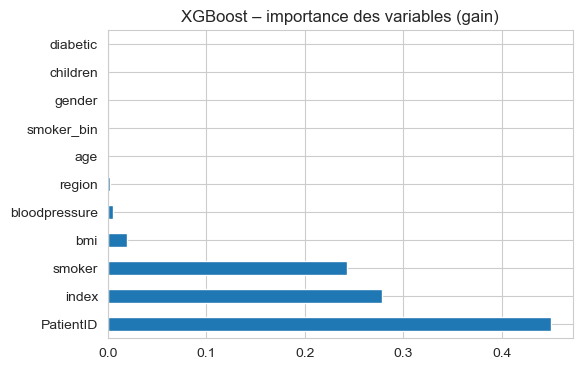

In [74]:
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='barh', figsize=(6,4))
plt.title("XGBoost ‚Äì importance des variables (gain)")
plt.show()

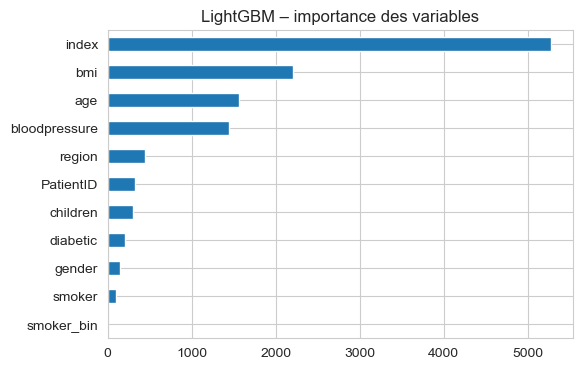

In [75]:
importances_lgbm = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values()
importances_lgbm.plot(kind='barh', figsize=(6,4))
plt.title("LightGBM ‚Äì importance des variables")
plt.show()